In [1]:
import pyspark
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import *
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
spark = SparkSession.builder.master("local[2]").getOrCreate()
sc = spark.sparkContext

In [3]:
df=spark.read.csv("data/completed.csv", header=True)
df=df.select(df['username'].cast('int'),df['anime_id'].cast('int'),df['score'].cast('float'))
df=df.na.drop()
df.printSchema()

root
 |-- username: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- score: float (nullable = true)



In [13]:
df_train, df_test = df.randomSplit([0.8, 0.2])
print df_train.count()
print df_test.count()

5034356
1260035


In [4]:
df.show()


+--------+--------+-----+
|username|anime_id|score|
+--------+--------+-----+
|       1|       1| 60.0|
|       1|      30| 85.0|
|       1|      32| 85.0|
|       1|      79| 60.0|
|       1|     226| 35.0|
|       1|     227| 60.0|
|       1|     339| 60.0|
|       1|     356| 60.0|
|       1|     433| 35.0|
|       1|     759| 85.0|
|       1|     770| 85.0|
|       1|     889| 60.0|
|       1|    1195| 60.0|
|       1|    1535| 60.0|
|       1|    1575| 60.0|
|       1|    1689| 85.0|
|       1|    1943| 85.0|
|       1|    2001| 60.0|
|       1|    2167| 35.0|
|       1|    2236| 60.0|
+--------+--------+-----+
only showing top 20 rows



In [5]:
df.describe().show()

+-------+-----------------+-----------------+------------------+
|summary|         username|         anime_id|             score|
+-------+-----------------+-----------------+------------------+
|  count|          6294391|          6294391|           6294391|
|   mean|33073.78466590334|9977.269728556743|  56.6542702860372|
| stddev|28598.69684457577|8720.462189791226|35.259854390094766|
|    min|                1|                1|               0.0|
|    max|            96981|            99217|             255.0|
+-------+-----------------+-----------------+------------------+



In [6]:
als_model = ALS(
    itemCol='anime_id',
    userCol='username',
    ratingCol='score',
    nonnegative=True,
    regParam=0.1,
    rank=10
)

In [14]:
recommender = als_model.fit(df_train)

In [15]:
test_input = df_test.select(df_test['username'],df_test['anime_id'])

In [24]:
predictions = recommender.transform(test_input)
predictions = predictions.join(df_test, (predictions.username==df_test.username) & (predictions.anime_id==df_test.anime_id))
predictions.show()

+--------+--------+----------+--------+--------+-----+
|username|anime_id|prediction|username|anime_id|score|
+--------+--------+----------+--------+--------+-----+
|       4|     457| 84.625854|       4|     457|100.0|
|       7|   10448| 45.243324|       7|   10448| 60.0|
|       8|    9690|  75.67179|       8|    9690| 80.0|
|      13|    1254|   72.7676|      13|    1254| 50.0|
|      13|   10715|  73.07674|      13|   10715| 60.0|
|      14|    8422| 63.907085|      14|    8422| 60.0|
|      15|   16035|  68.91614|      15|   16035| 70.0|
|      20|     121| 2.6179876|      20|     121|  0.0|
|      20|   18295| 11.374637|      20|   18295|  0.0|
|      23|    5355|  60.52243|      23|    5355| 30.0|
|      32|    4540| 52.538273|      32|    4540| 60.0|
|      36|    1544|  65.17951|      36|    1544| 60.0|
|      40|     597| 57.238167|      40|     597| 70.0|
|      40|    9135| 60.635155|      40|    9135| 50.0|
|      44|     357| 57.094296|      44|     357| 80.0|
|      44|

In [33]:
compare=predictions.select(predictions['prediction'], predictions['score'])
compare=compare.na.fill(0)
compare.describe().show()

+-------+------------------+------------------+
|summary|        prediction|             score|
+-------+------------------+------------------+
|  count|           1264027|           1264027|
|   mean|56.616472602271976|56.668744417642976|
| stddev| 30.41843866590231|35.243079849121564|
|    min|               0.0|               0.0|
|    max|         733.15625|             255.0|
+-------+------------------+------------------+



In [34]:
compare.createOrReplaceTempView("Predictions")
result = spark.sql('''
    SELECT AVG((prediction-score)*(prediction-score)) as MSE
    FROM Predictions
    ''')
result.show()

+----------------+
|             MSE|
+----------------+
|334.629841923209|
+----------------+



In [35]:
result.collect()[0][0]

334.629841923209

In [41]:
def grid_search_plot(x_axis, y_axis):
    for k in range(16,20):
        x_axis.append(k)
        als_model = ALS(
            itemCol='anime_id',
            userCol='username',
            ratingCol='score',
            nonnegative=True,
            regParam=0.1,
            rank=k
        )
        recommender = als_model.fit(df_train)
        test_input = df_test.select(df_test['username'],df_test['anime_id'])
        predictions = recommender.transform(test_input)
        predictions = predictions.join(df_test, (predictions.username==df_test.username) & (predictions.anime_id==df_test.anime_id))
        compare=predictions.select(predictions['prediction'], predictions['score'])
        compare=compare.na.fill(0)
        compare.createOrReplaceTempView("Predictions")
        result = spark.sql('''
            SELECT AVG((prediction-score)*(prediction-score)) as MSE
            FROM Predictions
            ''')
        MSE=result.collect()[0][0]
        y_axis.append(MSE)
        print k, MSE
    x_axis=np.array(x_axis)
    y_axis=np.array(y_axis)
    fig, ax = plt.subplots()
    ax.plot(x_axis, y_axis)
    plt.show()


3 351.443359554
4 342.192922389
5 341.690327737
6 338.939099265
7 337.296841067
8 339.097513809
9 337.708098652
10 334.629841923
11 335.543051397
12 335.788521798
13 335.768317317
14 335.46277777
15 338.829453661


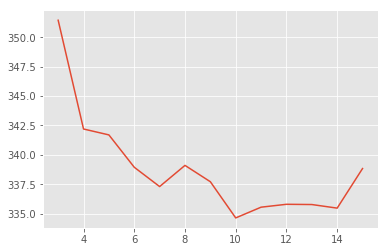

In [37]:
grid_search_plot()

16 336.734638183
17 337.97129506
18 337.254028785
19 338.254838945


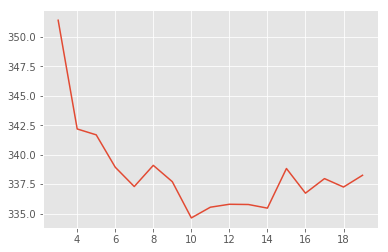

In [42]:
x_axis=[3,4,5,6,7,8,9,10,11,12,13,14,15]
y_axis=[351.43, 342.19, 341.69, 338.94, 337.297, 339.097, 337.71, 334.63, 335.54, 335.79, 335.77,335.462, 338.83]
grid_search_plot(x_axis, y_axis)